In [1]:
%pylab inline

from jla_data_fix import *
import pymc3 as pymc
import scipy.integrate as si

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
hubble = 2E-18
sol=3e08

In [3]:
allz = hstack(zs)
allmsb = hstack(msbs)
allmsbe = hstack(msbes)

In [18]:
# Cosmology Functions

def friedmann(z, omegaB):
    model = omegaB * ((1+z)**3) + (1-omegaB)
    
    return hubble * sqrt(model)


def integrand(x, b):
    return friedmann(x, b)**(-1)


def sk(z, omegaB):
    return float((si.quad(integrand, 0, z, args=(omegaB)))[0])


def lumdist(z, omegaB):
    return sk(z, omegaB) * (sol/hubble)


def flux(z, omegaB, lpeak):
    return lpeak/(4 * np.pi * (lumdist(z, omegaB)*(1+z))**2)


def msbcalc(z, omegaB, lpeak):
    lpeak = lpeak*1e39 # sssh mcmc
    return -20.45 - 2.5*log10(1E-4 * flux(z, omegaB, lpeak))

vecmsbcalc = vectorize(msbcalc)

In [19]:
basic_model = pymc.Model()

with basic_model:
    omegaB = pymc.Normal('omegaB', mu=0.3, sd=0.1)
    lpeak = pymc.Normal('lpeak', mu=4, sd=2)
    
    #expected value
    mu = vecmsbcalc(allz, omegaB, lpeak)
    
    #liklehood
    Y_obs = -0.5*(((allmsb - mu)/(allmsbe))**2).sum()

error: Supplied function does not return a valid float.

In [20]:
map_estimate = pymc.find_MAP(model=basic_model)
print(map_estimate)

{'omegaB': array(0.3), 'lpeak': array(4.0)}


In [21]:
from scipy import optimize

map_estimate = pymc.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

print(map_estimate)

{'omegaB': array(0.2999999999683607), 'lpeak': array(3.999999999968361)}


In [29]:
from pymc3 import NUTS, sample

with basic_model:

    # obtain starting values via MAP
    start = pymc.find_MAP(fmin=optimize.fmin_powell)

    # draw 2000 posterior samples
    trace = sample(2000, start=start) 

Assigned NUTS to omegaB
Assigned NUTS to lpeak
 [-----------------100%-----------------] 2000 of 2000 complete in 0.4 sec

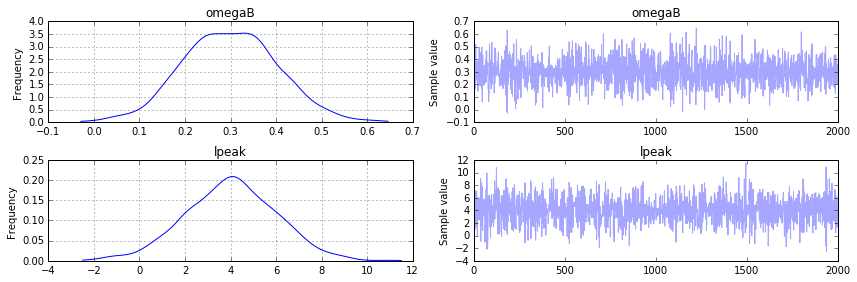

In [30]:
from pymc3 import traceplot

traceplot(trace);

In [31]:
from pymc3 import summary

summary(trace)


omegaB:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.300            0.104            0.002            [0.103, 0.508]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.100          0.229          0.298          0.370          0.508


lpeak:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.020            2.013            0.051            [-0.021, 7.877]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.014         2.686          4.050          5.380          7.916



In [32]:
import pymc as pm

In [33]:
def make_model(b, l):
    omegaB = pm.Normal('omegab', mu=b, sd=0.1, value=0.3)
    leff = pm.Normal('leff', mu=l, sd=2, value=4)
    
    @pymc.deterministic
    def mu(b=omegaB, l=leff):
        return vecmsbeff(allz, b, l)
    
    return locals()

In [34]:
M = pm.Model(make_model(0.3, 4))

ValueError: No value given for parent tau